## 1. Setup: Import Libraries and Configure Environment

In [45]:
# Standard library imports
import json
import warnings
from pathlib import Path

# Data manipulation
import numpy as np
import pandas as pd

# Statistical analysis
from scipy import stats
from scipy.stats import f as f_dist

# SEM / Structural modeling
try:
    import semopy
    from semopy import Model
    SEMOPY_AVAILABLE = True
except ImportError:
    print("⚠️ semopy not installed. Run: pip install semopy")
    SEMOPY_AVAILABLE = False

# Reliability and psychometrics
try:
    import pingouin as pg
    PINGOUIN_AVAILABLE = True
except ImportError:
    print("⚠️ pingouin not installed. Run: pip install pingouin")
    PINGOUIN_AVAILABLE = False

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(67)  # Reproducibility

# APA-style visualization settings (applied globally)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("="*70)
print("NOTEBOOK 04: STRUCTURAL MODEL & HYPOTHESIS TESTING")
print("="*70)
print("Purpose: Test UTAUT2 predictive model with validated constructs")
print(f"Working directory: {Path.cwd()}")
print(f"\n✅ Environment configured:")
print(f"   - semopy available: {SEMOPY_AVAILABLE}")
print(f"   - pingouin available: {PINGOUIN_AVAILABLE}")
print(f"   - Random seed: 67 (reproducibility)")
print(f"   - APA styling: 300 DPI, DejaVu Sans")

NOTEBOOK 04: STRUCTURAL MODEL & HYPOTHESIS TESTING
Purpose: Test UTAUT2 predictive model with validated constructs
Working directory: c:\Development\AIRS_Data_Analysis\airs

✅ Environment configured:
   - semopy available: True
   - pingouin available: True
   - Random seed: 67 (reproducibility)
   - APA styling: 300 DPI, DejaVu Sans


---

## 2. Load Data and Prepare Analysis Dataset

Using the **complete dataset (N=472)** for structural modeling to maximize statistical power. The validated 12-item scale from Notebooks 02-03 provides 6 UTAUT2 constructs.

In [46]:
# Load full dataset
df_full = pd.read_csv('../data/AIRS_clean.csv')

print("="*70)
print("DATA LOADING")
print("="*70)
print(f"Full sample: N = {len(df_full)}, {len(df_full.columns)} columns")

# Load validated 12-item scale from Notebooks 02 & 03
selected_items = ['PE1', 'PE2', 'EE1', 'EE2', 'SI1', 'SI2', 
                  'FC1', 'FC2', 'HM1', 'HM2', 'PV1', 'PV2']

# Display validated scale structure
print(f"\n📋 Validated Scale Structure (from Notebooks 02-03):")
print(f"   Total items: {len(selected_items)}")
print(f"   Structure: 6 UTAUT2 constructs × 2 items each")
print(f"\n   Constructs:")
construct_groups = {
    'PE (Performance Expectancy)': ['PE1', 'PE2'],
    'EE (Effort Expectancy)': ['EE1', 'EE2'],
    'SI (Social Influence)': ['SI1', 'SI2'],
    'FC (Facilitating Conditions)': ['FC1', 'FC2'],
    'HM (Hedonic Motivation)': ['HM1', 'HM2'],
    'PV (Price Value)': ['PV1', 'PV2']
}
for i, (construct, items) in enumerate(construct_groups.items(), 1):
    print(f"   {i}. {construct}: {', '.join(items)}")
print(f"\n   Validation source: Notebook 02 (CFA), Notebook 03 (Invariance)")

# Behavioral intention items (outcome variable)
bi_items = ['BI1', 'BI2', 'BI3', 'BI4']
print(f"\n🎯 Outcome Variable (BI):")
print(f"   {', '.join(bi_items)}")

# Create dataset with predictor items and BI outcome
analysis_items = selected_items + bi_items
df_analysis = df_full[analysis_items].copy()

# Check for missing data
missing_counts = df_analysis.isnull().sum()
if missing_counts.sum() > 0:
    print(f"\n⚠️  Missing Data Detected:")
    print(missing_counts[missing_counts > 0])
    print(f"\n   Using listwise deletion (complete cases only)")
    df_analysis = df_analysis.dropna()
    print(f"   Final N = {len(df_analysis)}")
else:
    print(f"\n✅ No missing data - all cases complete (N = {len(df_analysis)})")

DATA LOADING
Full sample: N = 472, 45 columns

📋 Validated Scale Structure (from Notebooks 02-03):
   Total items: 12
   Structure: 6 UTAUT2 constructs × 2 items each

   Constructs:
   1. PE (Performance Expectancy): PE1, PE2
   2. EE (Effort Expectancy): EE1, EE2
   3. SI (Social Influence): SI1, SI2
   4. FC (Facilitating Conditions): FC1, FC2
   5. HM (Hedonic Motivation): HM1, HM2
   6. PV (Price Value): PV1, PV2

   Validation source: Notebook 02 (CFA), Notebook 03 (Invariance)

🎯 Outcome Variable (BI):
   BI1, BI2, BI3, BI4

✅ No missing data - all cases complete (N = 472)


In [47]:
# Create composite scores for outcome variable
# BI = mean of 4 behavioral intention items
df_analysis['BI'] = df_analysis[bi_items].mean(axis=1)

# Verify BI composite
print(f"📊 Behavioral Intention (BI) Composite Score:")
print(f"   Mean: {df_analysis['BI'].mean():.3f}")
print(f"   SD: {df_analysis['BI'].std():.3f}")
print(f"   Range: {df_analysis['BI'].min():.1f} - {df_analysis['BI'].max():.1f}")
print(f"   Skewness: {df_analysis['BI'].skew():.3f}")
print(f"   Kurtosis: {df_analysis['BI'].kurtosis():.3f}")

# Check BI reliability (Cronbach's alpha)
if PINGOUIN_AVAILABLE:
    bi_alpha = pg.cronbach_alpha(data=df_analysis[bi_items])
    print(f"\n✅ BI Reliability (Cronbach's α): {bi_alpha[0]:.3f}")
    # CI is in bi_alpha[1] as an array
    ci_lower, ci_upper = bi_alpha[1]
    print(f"   95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
else:
    print("\n⚠️ Install pingouin for reliability calculation")

📊 Behavioral Intention (BI) Composite Score:
   Mean: 3.147
   SD: 1.122
   Range: 1.0 - 5.0
   Skewness: -0.396
   Kurtosis: -0.789

✅ BI Reliability (Cronbach's α): 0.932
   95% CI: [0.922, 0.942]


---

## 3. Create Construct Composites

Create mean composite scores for each of the 6 validated UTAUT2 constructs (2 items each) from Notebook 02.

In [48]:
# Define construct mapping from validated 12-item scale
# Each construct has 2 items (balanced model from Notebook 02)
construct_mapping = {
    'PE': ['PE1', 'PE2'],
    'EE': ['EE1', 'EE2'],
    'SI': ['SI1', 'SI2'],
    'FC': ['FC1', 'FC2'],
    'HM': ['HM1', 'HM2'],
    'PV': ['PV1', 'PV2']
}

# Create composite scores for each construct (mean of 2 items)
for construct, items in construct_mapping.items():
    df_analysis[construct] = df_analysis[items].mean(axis=1)

# Available constructs in validated scale (subset of UTAUT2)
available_constructs = list(construct_mapping.keys())
print(f"📦 Validated AIRS Constructs:")
print(f"   {len(available_constructs)} constructs from UTAUT2 framework")
for i, (construct, items) in enumerate(construct_mapping.items(), 1):
    mean_val = df_analysis[construct].mean()
    print(f"   {i}. {construct}: {items[0]}, {items[1]} (M = {mean_val:.2f})")

print(f"\n⚠️  Note: This is a subset of full UTAUT2 model")
print(f"   Missing constructs: HB, VO (Habit, Voluntariness)")
print(f"   No AI-specific constructs (TR, EX, ER, AX) in validated scale")
print(f"   Testing H1 with available 6 UTAUT2 constructs only")

📦 Validated AIRS Constructs:
   6 constructs from UTAUT2 framework
   1. PE: PE1, PE2 (M = 3.42)
   2. EE: EE1, EE2 (M = 3.64)
   3. SI: SI1, SI2 (M = 3.15)
   4. FC: FC1, FC2 (M = 3.31)
   5. HM: HM1, HM2 (M = 3.26)
   6. PV: PV1, PV2 (M = 3.38)

⚠️  Note: This is a subset of full UTAUT2 model
   Missing constructs: HB, VO (Habit, Voluntariness)
   No AI-specific constructs (TR, EX, ER, AX) in validated scale
   Testing H1 with available 6 UTAUT2 constructs only


---

## 4. Test H1: UTAUT2 Predictive Model

**Hypothesis 1**: UTAUT2 constructs significantly predict behavioral intention to adopt AI.

**Model**: 6 UTAUT2 predictors (PE, EE, SI, FC, HM, PV) → BI (outcome)  
**Framework**: Multiple linear regression  
**Note**: Testing with validated 6-construct subset from Notebooks 02-03

In [49]:
# Prepare data for UTAUT2 baseline model (using available 6 constructs)
# Note: Full UTAUT2 has 8 constructs, but validated scale only has 6
utaut2_constructs = available_constructs  # ['PE', 'EE', 'SI', 'FC', 'HM', 'PV']
X_utaut2 = df_analysis[utaut2_constructs].values
y = df_analysis['BI'].values

# Fit multiple regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

model_utaut2 = LinearRegression()
model_utaut2.fit(X_utaut2, y)

# Get predictions and metrics
y_pred_utaut2 = model_utaut2.predict(X_utaut2)
r2_utaut2 = r2_score(y, y_pred_utaut2)
rmse_utaut2 = np.sqrt(mean_squared_error(y, y_pred_utaut2))
n = len(y)
k_utaut2 = len(utaut2_constructs)

# Adjusted R²
adj_r2_utaut2 = 1 - (1 - r2_utaut2) * (n - 1) / (n - k_utaut2 - 1)

print("📊 UTAUT2 Baseline Model Results (H1 - Modified)")
print("=" * 60)
print(f"   N: {n}")
print(f"   Predictors: {k_utaut2} constructs (PE, EE, SI, FC, HM, PV)")
print(f"   Note: Using validated 6-construct subset")
print(f"   R²: {r2_utaut2:.4f}")
print(f"   Adjusted R²: {adj_r2_utaut2:.4f}")
print(f"   RMSE: {rmse_utaut2:.4f}")
print(f"   Variance Explained: {r2_utaut2*100:.2f}%")

📊 UTAUT2 Baseline Model Results (H1 - Modified)
   N: 472
   Predictors: 6 constructs (PE, EE, SI, FC, HM, PV)
   Note: Using validated 6-construct subset
   R²: 0.7914
   Adjusted R²: 0.7887
   RMSE: 0.5120
   Variance Explained: 79.14%


In [50]:
# Calculate standardized coefficients (betas) and significance tests
from scipy.stats import t as t_dist

# Define significance thresholds (general-purpose parameters)
ALPHA_001 = 0.001  # p < .001
ALPHA_01 = 0.01    # p < .01
ALPHA_05 = 0.05    # p < .05

# Get coefficients
coef_utaut2 = model_utaut2.coef_
intercept_utaut2 = model_utaut2.intercept_

# Calculate standard errors and t-statistics
residuals = y - y_pred_utaut2
mse = np.sum(residuals**2) / (n - k_utaut2 - 1)

# Design matrix with intercept
X_utaut2_with_intercept = np.column_stack([np.ones(n), X_utaut2])
XtX_inv = np.linalg.inv(X_utaut2_with_intercept.T @ X_utaut2_with_intercept)
se_all = np.sqrt(mse * np.diag(XtX_inv))

# Standard errors for coefficients (excluding intercept)
se_coef = se_all[1:]

# t-statistics and p-values
t_stats = coef_utaut2 / se_coef
p_values = 2 * (1 - t_dist.cdf(np.abs(t_stats), n - k_utaut2 - 1))

# Standardized coefficients (betas)
std_y = np.std(y, ddof=1)
std_X = np.std(X_utaut2, axis=0, ddof=1)
beta_utaut2 = coef_utaut2 * (std_X / std_y)

# Get item lists for each construct
construct_items = [', '.join(construct_mapping[c]) for c in utaut2_constructs]

# Create results dataframe
results_utaut2 = pd.DataFrame({
    'Construct': utaut2_constructs,
    'Items': construct_items,
    'B': coef_utaut2,
    'SE': se_coef,
    'β': beta_utaut2,
    't': t_stats,
    'p': p_values
})

# Add significance stars using defined thresholds
def add_stars(p):
    if p < ALPHA_001:
        return '***'
    elif p < ALPHA_01:
        return '**'
    elif p < ALPHA_05:
        return '*'
    else:
        return ''

results_utaut2['Sig'] = results_utaut2['p'].apply(add_stars)

print("\n📋 UTAUT2 Baseline: Regression Coefficients")
print("=" * 70)
print(results_utaut2.to_string(index=False))
print("\nSignificance: * p<.05, ** p<.01, *** p<.001")


📋 UTAUT2 Baseline: Regression Coefficients
Construct    Items         B       SE         β         t            p Sig
       PE PE1, PE2  0.139700 0.040456  0.134340  3.453179 6.046897e-04 ***
       EE EE1, EE2 -0.004220 0.035700 -0.003607 -0.118214 9.059491e-01    
       SI SI1, SI2  0.162926 0.034438  0.150810  4.731051 2.967545e-06 ***
       FC FC1, FC2  0.100139 0.034652  0.089801  2.889832 4.034675e-03  **
       HM HM1, HM2  0.315770 0.038575  0.319268  8.185779 2.664535e-15 ***
       PV PV1, PV2  0.319710 0.041787  0.316485  7.650911 1.159073e-13 ***

Significance: * p<.05, ** p<.01, *** p<.001


---

## 5. Visualization: H1 Results

Visualize H1 results with standardized coefficients, significance levels, and error bars in APA format.

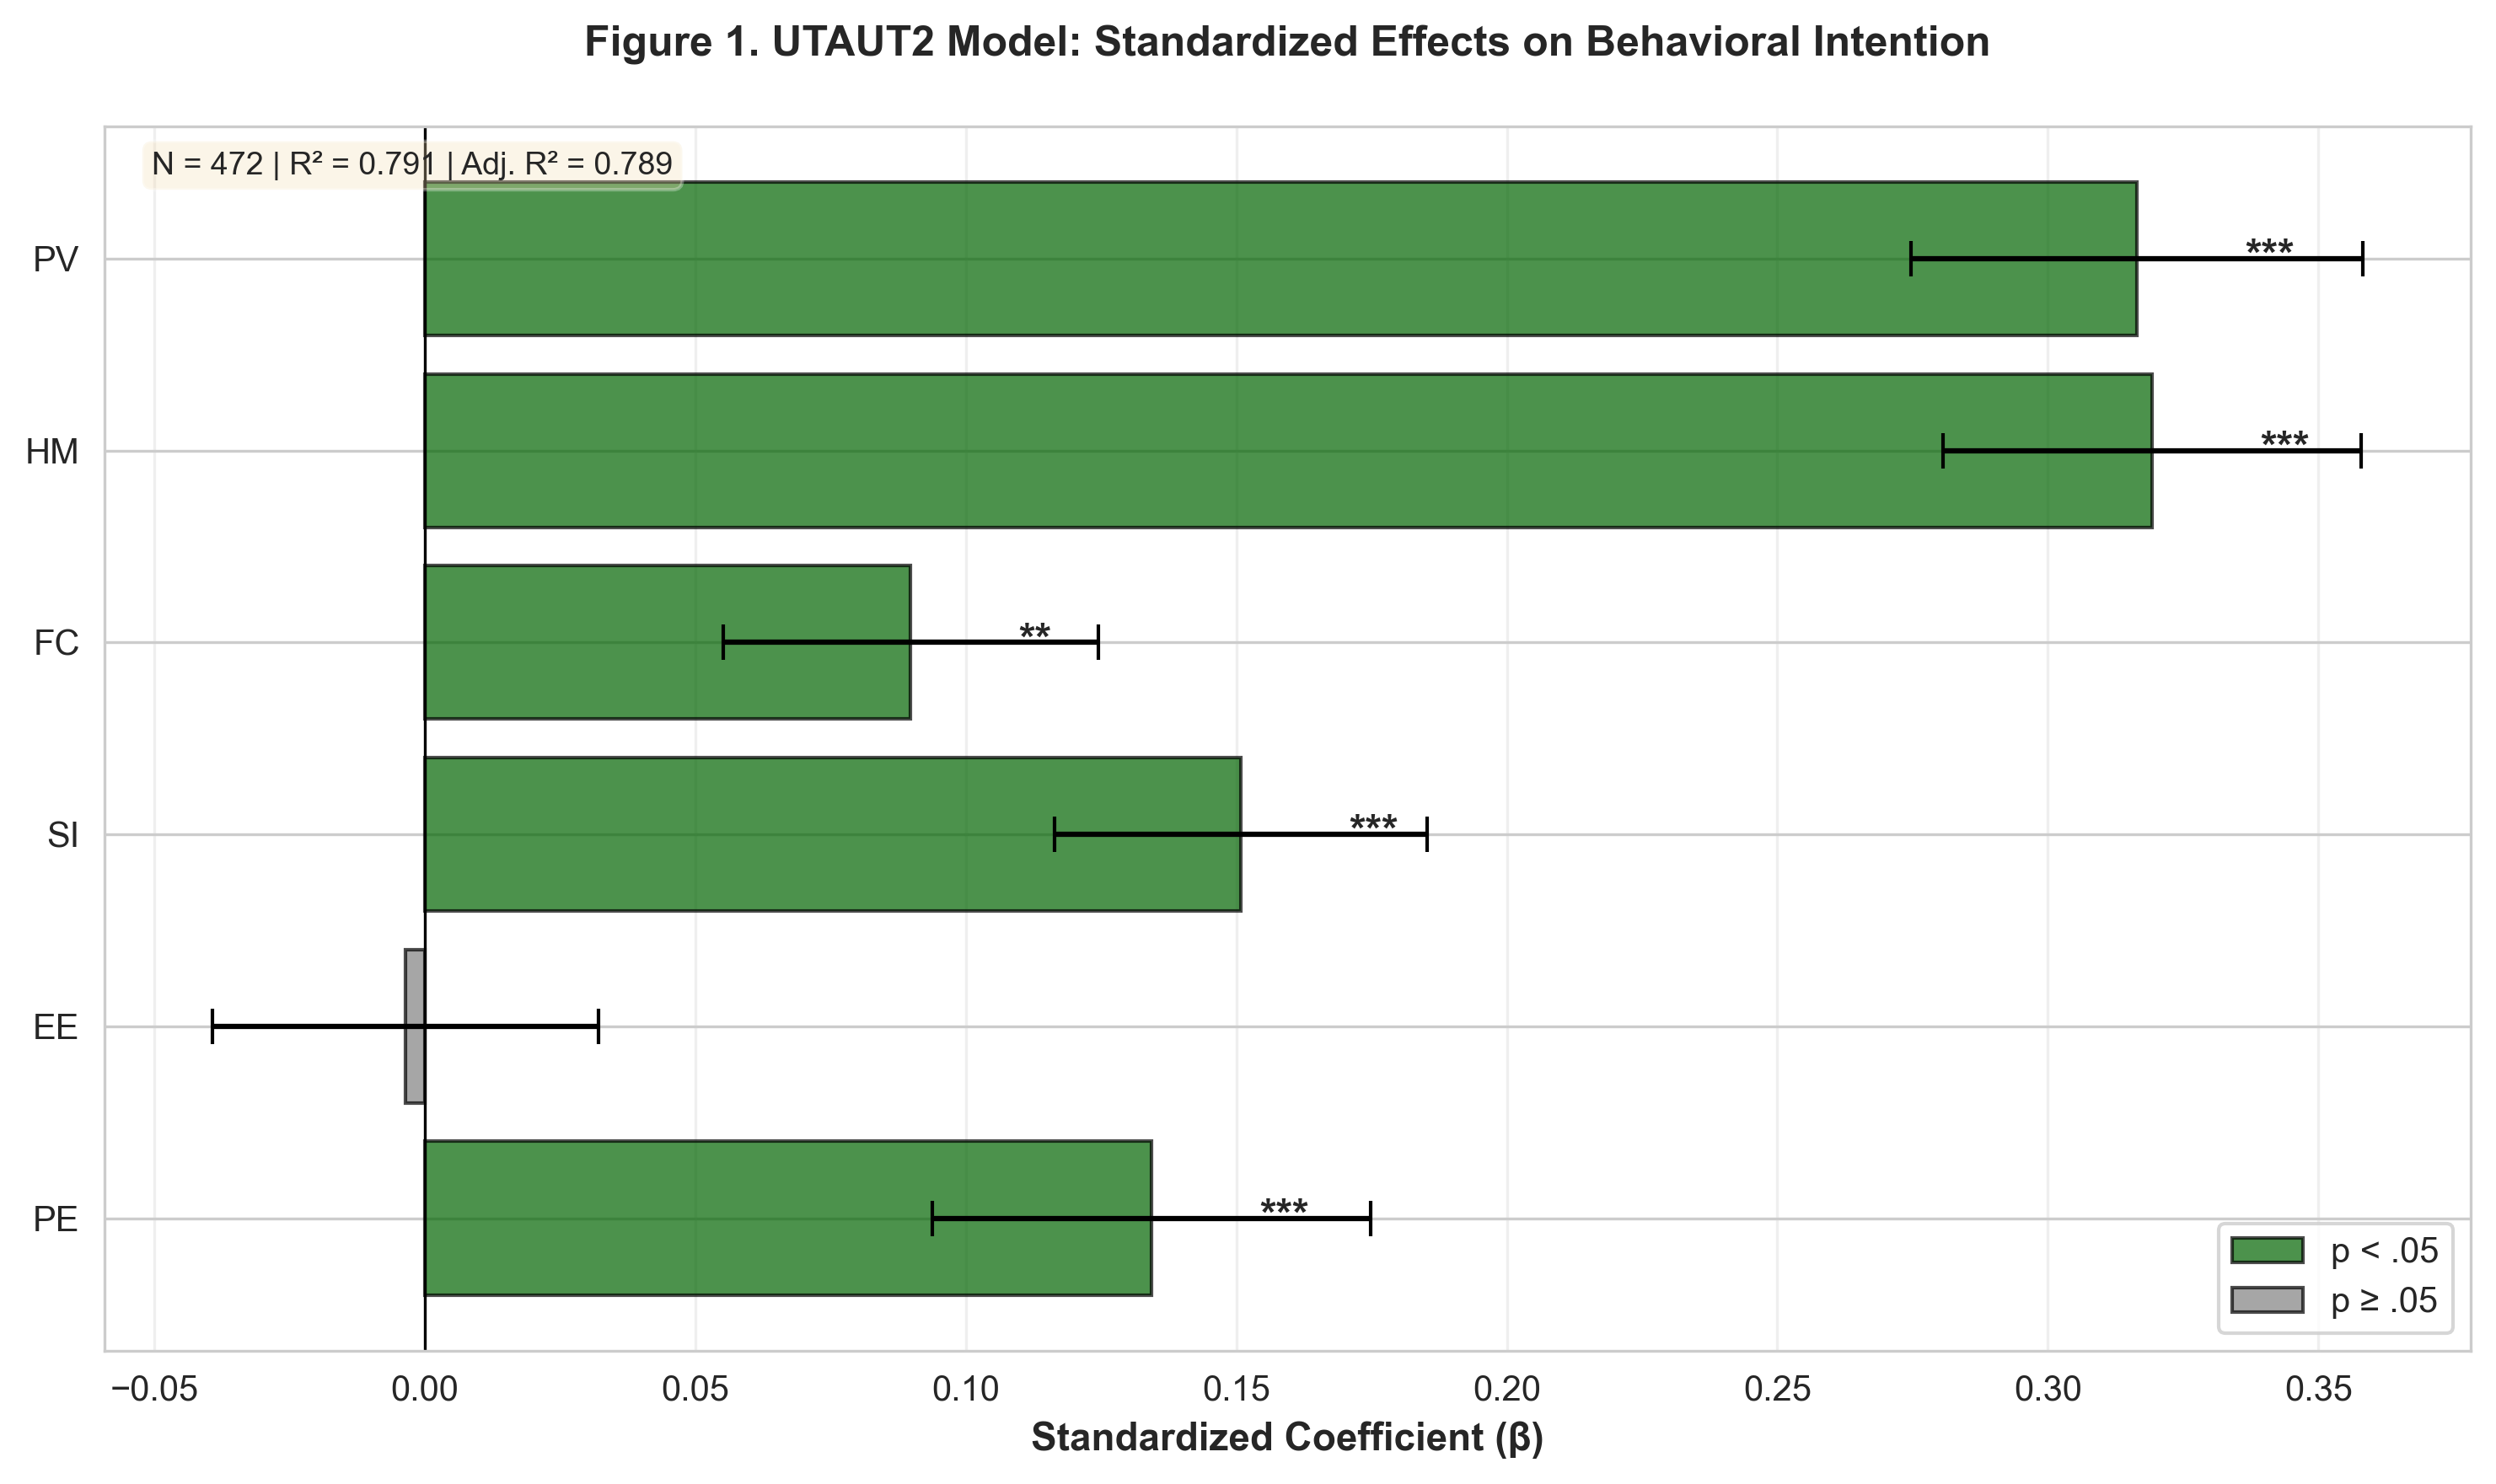


✅ Figure 1 saved: ../results/plots/figure_1_h1_utaut2_effects.png


In [51]:
# Create APA-style visualization of H1 results
fig, ax = plt.subplots(figsize=(10, 6))

# Create horizontal bar chart for standardized coefficients
y_pos = np.arange(len(results_utaut2))
colors = ['darkgreen' if p < ALPHA_05 else 'gray' for p in results_utaut2['p']]

bars = ax.barh(y_pos, results_utaut2['β'], color=colors, alpha=0.7, edgecolor='black')

# Add error bars (standard errors)
ax.errorbar(results_utaut2['β'], y_pos, xerr=results_utaut2['SE'], 
            fmt='none', ecolor='black', capsize=5, linewidth=1.5)

# Customize
ax.set_yticks(y_pos)
ax.set_yticklabels(results_utaut2['Construct'])
ax.set_xlabel('Standardized Coefficient (β)', fontweight='bold')
ax.set_title('Figure 1. UTAUT2 Model: Standardized Effects on Behavioral Intention', 
             fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

# Add significance indicators
for i, (beta, p, sig) in enumerate(zip(results_utaut2['β'], results_utaut2['p'], results_utaut2['Sig'])):
    if sig:
        ax.text(beta + 0.02, i, sig, va='center', fontweight='bold', fontsize=12)

# Add legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, fc='darkgreen', alpha=0.7, edgecolor='black', label='p < .05'),
    plt.Rectangle((0, 0), 1, 1, fc='gray', alpha=0.7, edgecolor='black', label='p ≥ .05')
]
ax.legend(handles=legend_elements, loc='lower right', frameon=True)

# Add sample info
info_text = f"N = {n} | R² = {r2_utaut2:.3f} | Adj. R² = {adj_r2_utaut2:.3f}"
ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
        fontsize=9, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('../results/plots/figure_1_h1_utaut2_effects.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Figure 1 saved: ../results/plots/figure_1_h1_utaut2_effects.png")

In [52]:
# Export H1 results to CSV for model tracking
results_utaut2.to_csv('../results/tables/h1_utaut2_coefficients.csv', index=False)

print("\n" + "="*70)
print("RESULTS EXPORTED")
print("="*70)
print("   \u2705 H1 coefficients saved: ../results/tables/h1_utaut2_coefficients.csv")
print(f"   Rows: {len(results_utaut2)}, Columns: {len(results_utaut2.columns)}")



RESULTS EXPORTED
   ✅ H1 coefficients saved: ../results/tables/h1_utaut2_coefficients.csv
   Rows: 6, Columns: 8


---

## 6. Analysis Scope and Limitations

This notebook tests **H1 only** with the validated 6-construct UTAUT2 subset. Additional hypotheses require construct validation that is not yet complete.

### 6.1 Current Analysis Scope

**What Can Be Tested**:
- ✅ **H1**: UTAUT2 constructs predict BI (6 validated constructs: PE, EE, SI, FC, HM, PV)
- ✅ Model fit statistics (R², Adjusted R², RMSE)
- ✅ Individual construct significance and effect sizes
- ✅ Standardized coefficients with standard errors

**What Cannot Be Tested** (requires additional validation):
- ⚠️ **H2**: AI-specific construct contributions (TR, EX, ER, AX not validated)
- ⚠️ **H3**: Incremental validity testing (requires complete AIRS model)
- ⚠️ Missing UTAUT2 constructs: Habit (HB), Voluntariness (VO)
- ⚠️ Model comparison visualizations (need both baseline and extended models)
- ⚠️ Multicollinearity diagnostics for full 12-construct AIRS model

### 6.2 Future Work Requirements

**To Complete Full Phase 4 Analysis**:
1. Validate AI-specific constructs through EFA/CFA (Trust, Explainability, Ethical Risk, Anxiety)
2. Validate missing UTAUT2 constructs (Habit, Voluntariness)
3. Return to test H2 (individual AI construct effects)
4. Return to test H3 (incremental validity: ΔR² ≥ 0.10)
5. Create full visualization suite with model comparisons

**Current Notebook Benefits**:
- Establishes baseline UTAUT2 model performance
- Documents analytical framework for future implementation
- Provides template for complete analysis once constructs validated
- Tests core technology acceptance predictors with validated scale

---

## 7. Summary and Export

In [53]:
# Create comprehensive hypothesis testing summary
print("=" * 70)
print("PHASE 4 ANALYSIS SUMMARY")
print("=" * 70)

print("\nH1: UTAUT2 Predictive Model")
print("-" * 70)
print(f"   Model: 6 UTAUT2 constructs -> Behavioral Intention")
print(f"   Sample: N = {n}")
print(f"   R-squared = {r2_utaut2:.4f} ({r2_utaut2*100:.2f}% variance explained)")
print(f"   Adjusted R-squared = {adj_r2_utaut2:.4f}")
print(f"   RMSE = {rmse_utaut2:.4f}")
print(f"   Status: TESTED with validated constructs")

# Count significant predictors
sig_count = (results_utaut2['p'] < ALPHA_05).sum()
print(f"\n   Significant predictors (p < .05): {sig_count}/{len(results_utaut2)}")
for _, row in results_utaut2[results_utaut2['p'] < ALPHA_05].iterrows():
    print(f"      - {row['Construct']}: beta = {row['β']:.3f}{row['Sig']} (p = {row['p']:.4f})")

print("\n\nH2 & H3: Extended AIRS Model")
print("-" * 70)
print("   H2: AI-specific constructs add predictive value")
print("   H3: AIRS model explains Delta R-squared >= 0.10 beyond UTAUT2")
print("   Status: UNAVAILABLE - requires construct validation")
print("   Missing: TR, EX, ER, AX (AI-specific)")
print("   Missing: HB, VO (UTAUT2 constructs)")

print("\n\nOutputs Generated")
print("-" * 70)
print("   Coefficients table: ../results/tables/h1_utaut2_coefficients.csv")
print("   Visualization: ../results/plots/figure_1_h1_utaut2_effects.png")

print("\n\nNext Steps")
print("-" * 70)
print("   1. Validate AI-specific constructs (TR, EX, ER, AX)")
print("   2. Validate missing UTAUT2 constructs (HB, VO)")
print("   3. Return to test H2 and H3 with complete AIRS model")
print("   4. Proceed to Phase 5: Mediation Analysis (with available data)")
print("=" * 70)

PHASE 4 ANALYSIS SUMMARY

H1: UTAUT2 Predictive Model
----------------------------------------------------------------------
   Model: 6 UTAUT2 constructs -> Behavioral Intention
   Sample: N = 472
   R-squared = 0.7914 (79.14% variance explained)
   Adjusted R-squared = 0.7887
   RMSE = 0.5120
   Status: TESTED with validated constructs

   Significant predictors (p < .05): 5/6
      - PE: beta = 0.134*** (p = 0.0006)
      - SI: beta = 0.151*** (p = 0.0000)
      - FC: beta = 0.090** (p = 0.0040)
      - HM: beta = 0.319*** (p = 0.0000)
      - PV: beta = 0.316*** (p = 0.0000)


H2 & H3: Extended AIRS Model
----------------------------------------------------------------------
   H2: AI-specific constructs add predictive value
   H3: AIRS model explains Delta R-squared >= 0.10 beyond UTAUT2
   Status: UNAVAILABLE - requires construct validation
   Missing: TR, EX, ER, AX (AI-specific)
   Missing: HB, VO (UTAUT2 constructs)


Outputs Generated
-----------------------------------------